# Quantification of tidal effects in Vietnam on Landsat satellite imagery 

**Author**: Ronja Lappe, 2020

<br/>

**Content of the script:**
1. Identification of low and high tide dates at Landsat acquisition time within a selected AOI
2. Selection of nearly cloud-free images at low and high tides (Creation of image pairs)
3. Shoreline detection for each image pair
4. Calculation of shoreline displacement between low and high tide
5. Statistics

<br/>

**Sea level data:**
http://uhslc.soest.hawaii.edu/data/?rq#uh381http://uhslc.soest.hawaii.edu/data/csv/rqds/pacific/hourly/h381a.csv

Available stations in Vietnam: 
- Qui Nhon, South-Central Vietnam (1994-2005, 2007-2018)
- Vung Tau, Southern Vietnam (1986-2002, 2007-2018)
- Hon Dau, Island in Northern Vietnam (1995)

### Setup

**Python packages**

In [1]:
import ee
import geemap
import geetools
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import datetime
import pytz
from pytz import timezone
import statistics as stat
import pickle
import warnings
import nbimporter
# my functions 
import utils

Importing Jupyter notebook from utils.ipynb


**Parameters**

In [2]:
# Sea level station 
station = "Qui Nhong" # name of station 
station_coordinates = [13.77500,109.25500] # coordinates of the station
local_timezone = "Asia/Ho_Chi_Minh" #for other options check: "pytz.all_timezones"

# Paths
station_file_name = "qui-nong1"
GEE_export_folder = "GEE_tidal_export"
station_data_path = os.path.join(os.path.join(os.getcwd(),"input"))
output_path = os.path.join(os.getcwd(),"output")

**Initiate Google Earth Engine**

In [6]:
try:
    ee.Initialize()
    print('GEE initialized')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

GEE initialized


In [8]:
try: 
    roi = utils.open_output(station_file_name+'_roi',output_path)
    print('File exists and has been loaded as:\nroi')
except:
    print('File not found. Interactively select your roi by uncommenting the next cell')

File not found. Interactively select your roi by uncommenting the next cell


In [10]:
# print interactive map
m1 = geemap.Map(center= station_coordinates,zoom=10)
m1

Map(center=[13.775, 109.255], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

In [16]:
# draw region of interest
try: 
    roi = utils.open_output(station_file_name+'_roi',output_path)
    print('File exists and has been loaded as:\nroi')
except:
    m1.draw_features
    roi = ee.FeatureCollection(m1.draw_features).geometry()
    utils.save_output(roi,station_file_name+'_roi',output_path)
    print('roi has been saved in directory.')

roi has been saved in directory.


## 1| Identification of low and high tide dates at Landsat aquisition time
- Cleaning of sea level data/ extraction of valid years
- Calculation of Landsat overpass time for each year
- Filtering of sea level data by Landsat acquisition hour
- Identification of low and high tide peaks (+/1 1 day)
- Creation of low and high tide date lists for each available year

*Output: low and high tide date lists*

#### 1.1| Functions 

In [9]:
def sea_level_prep(station_data):
    #read and clean sea level station data 
    station_data.columns = ['year','month','day','hour','sea_level'] # name columns
    station_data = station_data[station_data.sea_level >= 0] # remove all rows with sea level smaller zero
    return station_data

def get_valid_years(station_data):
    # remove entries with more than a thrid missing values 
    year_values = dict(station_data.year.value_counts())
    for key, value in dict(year_values).items():
            if value < 24*365/3:
                del year_values[key]
    years = list(year_values.keys())
    years.sort()
    print('Sea level station data available for the years',years,'at Station',station,',Vietnam.\n')
    return years

def select_landsat(year):
    #choose the right Landsat collection 
    if (year >= 1984) and (year <= 2011):
        ls_collection = "LANDSAT/LT05/C01/T1_SR"
    elif (year >= 2012) and (year <= 2013):
        ls_collection = "LANDSAT/LE07/C01/T1_SR"
    elif (year >= 2014) and (year <= 2020):
        ls_collection = "LANDSAT/LC08/C01/T1_SR"
    else:
        print("Choose year between 1984 and 2020")
    return ls_collection

def get_landsat_overpass_time(year, ls_collection, roi):
    # get a Landsat image for year and region of interest to extract the aquisition time
    ex_date1 = str(year)+"-01-01"
    ex_date2 = str(year)+"-12-31"   
    # filter Landsat archive
    ex_dataset = ee.ImageCollection(ls_collection)\
                      .filterDate(ex_date1, ex_date2)\
                      .filterBounds(roi)\
                      .filter(ee.Filter.lt('CLOUD_COVER',10))
    ex_list = ex_dataset.toList(10)
    try:
        # get example image
        ex_img = ee.Image(ex_list.get(0)).select(['B3', 'B2', 'B1']).clip(roi)
        # extract image properties 
        props = geemap.geemap.image_props(ex_img)
        props_info = props.getInfo()
        # get the Landsat aquisition time in GTM and convert to local time
        dt = props_info['system:time_start']
        dt_string = (dt[0:10]+" "+dt[11:19])
    except:
        dt_string = None
        print('       No Landsat imagery available.\n')
    return dt_string
        
def change_timezone(date_string, local_timezone):
    # change given time to time zone which has been selected in "Parameters"
    dt_object = datetime.datetime.strptime(date_string,"%Y-%m-%d %H:%M:%S")
    gmt = timezone("UTC") 
    dt_gmt = gmt.localize(dt_object)
    local = timezone(local_timezone)
    dt_local = dt_gmt.astimezone(local)
    return dt_local

def rounder(time):
    # round time to nearest hour
    if time.minute >= 30:
        return time.replace(second=0, microsecond=0, minute=0, hour=time.hour+1)
    else:
        return time.replace(second=0, microsecond=0, minute=0)

def get_landsat_aquisition_hour(local_time, year):
    dt_round = rounder(local_time)
    t = local_time.strftime("%H:%M:%S")
    t_round = dt_round.hour    
    return t_round

def get_sea_level_at_landsat_aquisition(sea_level_data, aquisition_time, year):
     # read and filter sea level station data
    sea_level_year = sea_level_data[(sea_level_data.year==year)]
    sea_level_landsat= sea_level_year[(sea_level_year.hour == aquisition_time)].reset_index(drop=True)
    doys = []
    dates = []
    for i, row in enumerate(sea_level_landsat.iterrows()):
        date = datetime.date(sea_level_landsat.iloc[i].year,sea_level_landsat.iloc[i].month,sea_level_landsat.iloc[i].day)
        doy = date.timetuple().tm_yday
        dates.append(date)
        doys.append(doy)
    sea_level_landsat['doy']=doys
    sea_level_landsat['date']=dates
    return sea_level_landsat 

def get_tide_doys(sea_level_data, min_distance, tide):
     # get doys of either high or low tide peaks +/-1 day
    if tide == 'high':   
        peaks = find_peaks(sea_level_data.sea_level,distance=min_distance)
    elif tide == 'low':
        reverse_peaks = sea_level_data.sea_level*-1
        peaks = find_peaks(reverse_peaks,distance=min_distance)
    else:
        print('Select either high or low tide.')
    peaks = list(peaks[0])
    # add day before and after hightest tide
    indices = []
    for i in peaks:
        if i+1 < len(sea_level_data) and i-1 > 0:
            i = int(i)
            indices.append(i)
            indices.append(i-1)        
            indices.append(i+1)
    doys = []
    for i in indices:
        doys.append(sea_level_data.doy.iloc[i])
    return indices,doys 

def doys_to_dates(sea_level_data, doys):
    # extract dates for each doy from dataframe
    dates = []
    for i in doys:
        date = np.array(sea_level_data.loc[sea_level_data['doy'] == i].date)[0]
        dates.append(str(date))
    dates.sort()
    return dates

def plot_peaks(sea_level_data, high_tide_indices, low_tide_indices,save_plot=False):
    # plot and save sea level graph for each year
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (25,5))
    p = sns.lineplot(ax=ax,
                    x=sea_level_data.doy,
                    y=sea_level_data.sea_level,
                    lw = 2,
                    marker = "o",
                    markerfacecolor='red',
                    markevery=[high_tide_indices]
                    )
    p = sns.lineplot(ax=ax,
                    x=sea_level_data.doy,
                    y=sea_level_data.sea_level,
                    lw = 0,
                    marker = "o",
                    markerfacecolor='green',
                    markevery=[low_tide_indices]
                    )    
    locs, labels = plt.xticks()
    plt.xticks(np.arange(0,365, step=5))
    plt.title("{}{}{}{}{}{}{}".format("Sea level at ",station, " station \n",year," at ",aquisition_hour," (appr. aquisition time for Landsat)"),
             fontsize=15)
    plt.ylabel("Sea level [mm]")
    plt.xlabel("DOY")
    if save_plot == True:
        if not os.path.exists(os.path.join(output_path,'figures')):
            os.makedirs(os.path.join(output_path,'figures'))
        plt.savefig(os.path.join(output_path,'figures','Sea_levels_'+station_file_name+'_'+str(year)))

#### 1.2| Main process

Files not found, processing started...
Sea level station data available for the years [1994, 1995, 1996, 2000, 2003, 2004, 2005] at Station Qui Nhong ,Vietnam.

1994 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1994-04-06 09:20:56+07:00 local time.
       Hence, sea level data at 9 h is selected.

1995 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1995-04-09 09:09:53+07:00 local time.
       Hence, sea level data at 9 h is selected.

1996 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1996-03-26 09:08:44+07:00 local time.
       Hence, sea level data at 9 h is selected.

2000 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 2000-04-22 09:35:40+07:00 local time.
       Hence, sea level data at 10 h is selected.

2003 : LANDSAT/LT05/C01/T1_SR has been selected
       No Landsat imagery available.

2004 : LANDSAT/LT05/C01/T1_SR has been selec

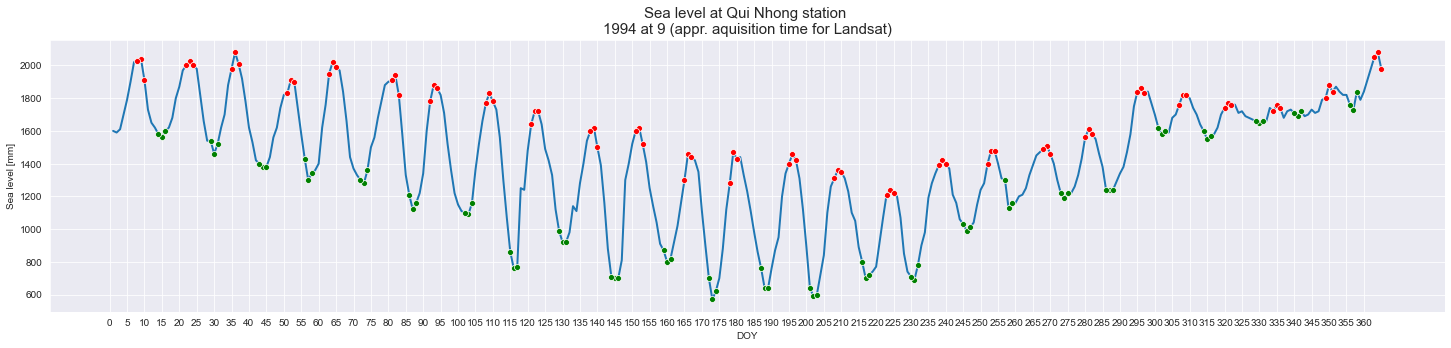

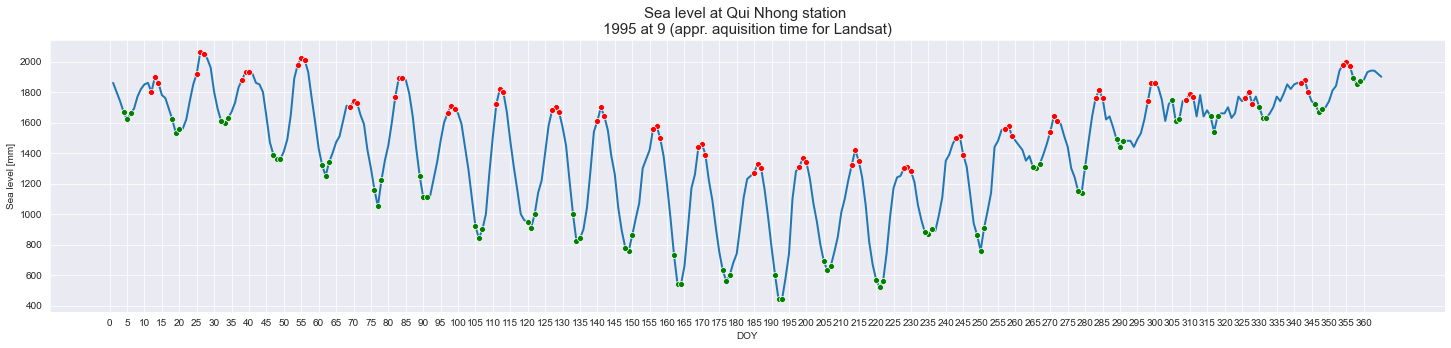

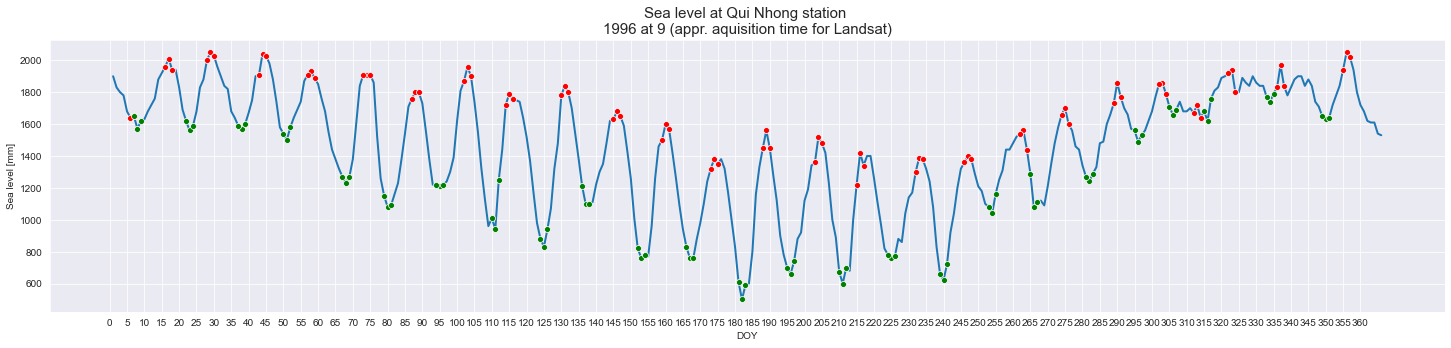

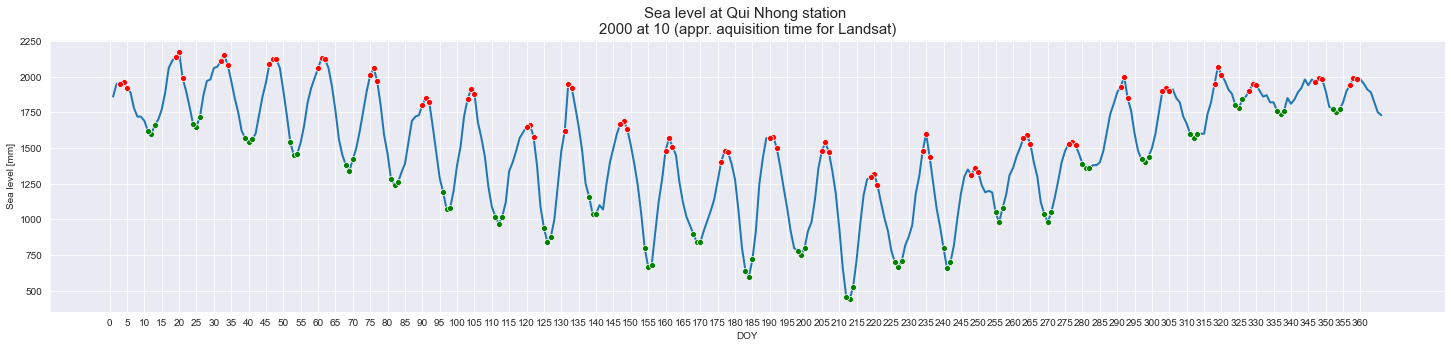

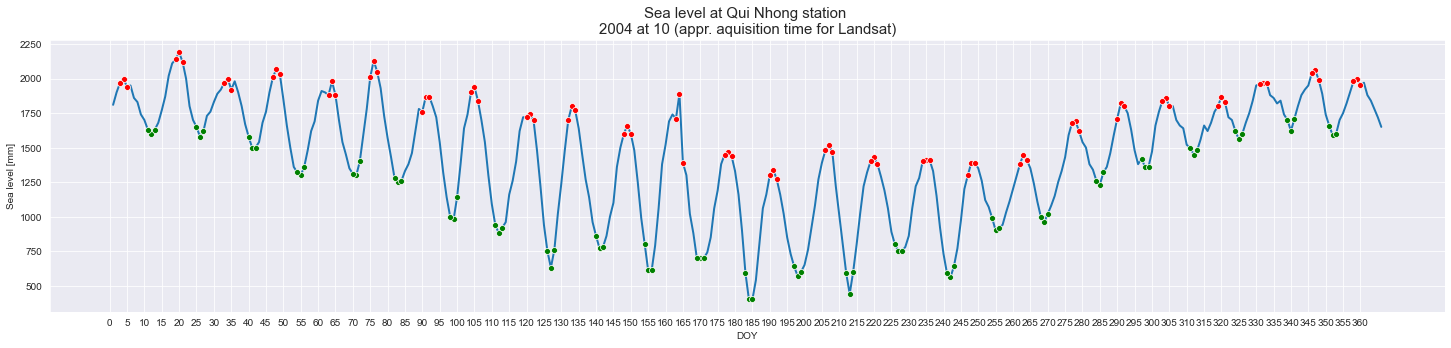

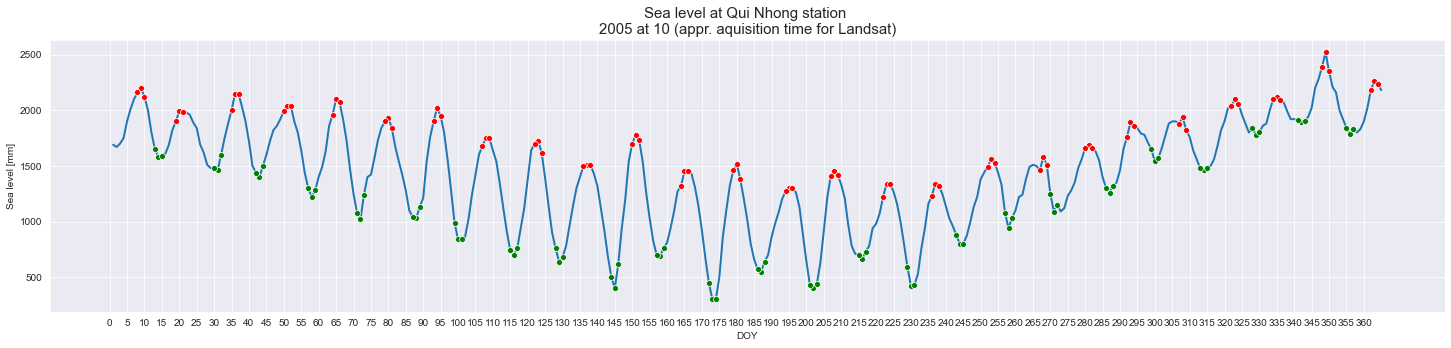

In [39]:
try:
    high_tide_dates = utils.open_output(station_file_name+'_high_tide_dates', output_path)
    low_tide_dates = utils.open_output(station_file_name+'_low_tide_dates', output_path)
    years_left = utils.open_output(station_file_name+'_years_left', output_path)
    print('Files exist and have been loaded as:\nhigh_tide_dates\nlow_tide_dates\nyears_left')
except:
    print('Files not found, processing started...')
    # output of main script will be saved in two lists:
    high_tide_dates = []
    low_tide_dates = []
    years_left = []

    # read and clean sea level station data
    sl_station_data  = pd.read_csv(os.path.join(station_data_path,station_file_name+".csv")) # read csv
    sl_station_data = sea_level_prep(sl_station_data)
    # create a list of years for which sea level data is available 
    years = get_valid_years(sl_station_data)
    # loop through available years to extract high- and low tide landsat images
    for i in years:
        year = i
        # select landsat sensor for each year
        ls_collection = select_landsat(year)
        print(year,':',ls_collection, 'has been selected')
        # get landsat overpass time within region of interest for each year
        overpass_time = get_landsat_overpass_time(year,ls_collection,roi)

        if overpass_time is not None:
        # change to local time zone 
            years_left.append(i)
            local_time = change_timezone(overpass_time,local_timezone)
            print('       Landsat images for roi aquired at',local_time,'local time.')
            # round local time to closest full hour (since only hourly sea level data is available)
            aquisition_hour = get_landsat_aquisition_hour(local_time,year)
            print('       Hence, sea level data at', aquisition_hour, 'h is selected.\n')
            # filter sea level data by year and landsat aquisition hour
            sea_level_landsat = get_sea_level_at_landsat_aquisition(sl_station_data, aquisition_hour,year)
            # identify doys of landsat aquisition at high tides (+/- 1)
            ht_doys = get_tide_doys(sea_level_landsat,10,'high')
            # identify doys of landsat aquisition at low tides (+/- 1)
            lt_doys = get_tide_doys(sea_level_landsat,10,'low')
            # convert doys to dates 
            ht_dates = doys_to_dates(sea_level_landsat,ht_doys[1])
            high_tide_dates.append(ht_dates)
            lt_dates = doys_to_dates(sea_level_landsat,lt_doys[1])
            low_tide_dates.append(lt_dates)
            # plot a chart with sea levels at Landsat aquisition time for each year with marked high and low tides
            plot_peaks(sea_level_landsat, ht_doys[0], lt_doys[0], save_plot=True) # I should save the plots at one point :)
    # save date_lists
    utils.save_output(high_tide_dates,station_file_name+'_high_tide_dates', output_path)
    utils.save_output(low_tide_dates,station_file_name+'_low_tide_dates', output_path)
    utils.save_output(years_left,station_file_name+'_years_left', output_path)

## 2| Selection of nearly cloud-free images at low and high tides
- Filtering Landsat SR archive by 3-day date ranges
- Calculation of cloud cover within AOI
- Filtering of selected images by cloud cover (< 20%)
- Cloud-masking on selected images (using sr_cloud_qa band, for LS8 pixel_qa band)
- Creation of daily mosaics
- Removal of mosaics covering < 2/3 of the AOI
- Creation of low and high tide image pairs (each high tide images receives the closest available low tide image or vice versa)

*Output: list of image pairs*

#### 2.1| Functions

**Python funtions**

In [10]:
def get_start_dates(date_list):
    # get start date for 3-days period to filter the Landsat image collection 
    dates = date_list[0::3]# choose every thrid date as "start"
    return dates

def get_end_dates(date_list):
    # get end date for 3-days period to filter the Landsat image collection 
    dates = date_list[2::3]
    return dates

def nearest(items, pivot):
    # function to find closest date in a list to a given date
    # credits to: Tamas Hegedus (https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date)
    return min(items, key=lambda x: abs(x - pivot))

def find_partners(dates1, dates2):
    # find closest dates in two lists
    pairs = []
    for i in dates1: 
        single = i
        pair = []
        pair.append(single.strftime('%Y-%m-%d'))
        partner = nearest(dates2,single)
        pair.append(partner.strftime('%Y-%m-%d'))
        pairs.append(pair)
    return pairs

**GEE API functions**

In [11]:
def gee_get_img_cols(ls_collection, dates1, dates2):
    # get image collection for specified date range and ROI 
    def add_collection(date):
        start = date # start date
        index = ee.List(dates1).indexOf(date) # get index of current date
        end = ee.List(dates2).get(index) # get index of end dates 
        col = ee.ImageCollection(ls_collection) \
            .filterBounds(roi) \
            .filterDate(start,end)
        return col
    return add_collection

def gee_remove_empty_collections(img_collection):
    return ee.Algorithms.If(ee.ImageCollection(img_collection).size().gt(0),img_collection)

def gee_get_aquisition_date(img):
    # get aquisition date from ee.Image
    img_date = str(img['properties']['Aquisition_date'])
    return img_date 

def gee_get_datetimes(image_collection):
    # get dates from all images in an image collection 
    datetimes = []
    for i in image_collection.getInfo():
        date = gee_get_aquisition_date(i)
        dt = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8:10]))
        datetimes.append(dt)
    return datetimes

def gee_SR_add_aoi_cc(img_collection):
    # calculate cloud cover within the ROI and add value to metadata of each image in image collection
    def wrap(img):
        qa = ee.Image(img).select('pixel_qa')
        cloud = qa.bitwiseAnd(1<<5).And(qa.bitwiseAnd(1<<7)).Or(qa.bitwiseAnd(1<<3))
        area_roi = roi.area(maxError = 0.01)
        area_img = cloud.multiply(ee.Image.pixelArea()) # create raster with area information of each pixel 
        mask_area = area_img.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = roi,
            scale = 30,
            maxPixels = 1e10)
        mask_area = ee.Number(mask_area.get('pixel_qa'))
        cc = mask_area.divide(area_roi).multiply(100)
        return ee.Image(img).set('ROI_cloud_cover',cc)
    with_aoi_cc = ee.ImageCollection(img_collection).map(wrap)
    return with_aoi_cc

def gee_SR_cloud_masking_L457(image_collection):
    # perform cloudmasking for Landsat 4,5 or 7
    def masking(img):
        mask = geetools.cloud_mask.landsat457SRCloudQA()
        masked = mask(img)
        return ee.Image(masked)
    masked = ee.ImageCollection(image_collection).map(masking)
    return masked

def gee_SR_cloud_masking_L8(image_collection):
    # perform cloudmasking for Landsat 8
    def masking(img):
        mask = geetools.cloud_mask.landsat8SRPixelQA()
        masked = mask(img)
        return ee.Image(masked)
    masked = ee.ImageCollection(image_collection).map(masking)
    return masked

def gee_create_cc_filter(x):
    # create cloud cover filter 
    def filter_cc(image_collection):
        filtered = ee.ImageCollection(image_collection).filter(ee.Filter.lt('ROI_cloud_cover', x))
        return filtered
    return filter_cc 

def gee_SR_create_mosaic(image_collection):
    # filter image collection with cloud cover filter and create a mosaic
    col = ee.ImageCollection(image_collection)
    col_list = col.toList(col.size())
    date = ee.String(ee.Image(col_list.get(0)).get('SENSING_TIME')).slice(0,10)
    def get_cc(img):
        cc = ee.Image(img).get('ROI_cloud_cover')
        return cc
    cloud_cover = col_list.map(get_cc)
    def get_id(img):
        ls_id = ee.Image(img).get('LANDSAT_ID')
        return ls_id
    landsat_id = col_list.map(get_id)
    mosaic = col.qualityMosaic('pixel_qa')
    return ee.Image(mosaic).set('Aquisition_date',date,
                     'ROI_cloud_cover',cloud_cover,
                     'Landsat_ID',landsat_id)

def gee_add_meta(tide,satellite):
    # add additional meta data to mosaic 
    def wrap(img):
        return ee.Image(img).set('tide',tide,
                                'satellite',satellite)
    return wrap

def gee_select_full_images(img):
    # check whether the mosaic covers at least 2/3 of the ROI 
    # calculate the roi area in square kilometres
    area_roi = roi.area(maxError = 0.001)
    area_roi_skm = ee.Number(area_roi).divide(1e6).round()
    # calculate mosaic area in sqaure kilometres
    binary = ee.Image(img).where(ee.Image(img),1) # assign value 1 do every valid pixel
    area_px = binary.multiply(ee.Image.pixelArea()) # create raster with area information of each pixel 
    # calculate area of mosaic within roi
    area_img = area_px.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = roi,
        scale = 30,
        maxPixels = 1e10)
    area_img_skm = ee.Number(area_img.get('B1')).divide(1e6).round()
    # select only mosaics that cover at least 2/3 of the roi area
    #(tolerance of 1/3 to include mosaics with masked clouds or almost fitting sizes)
    img_select = ee.Algorithms.If(area_img_skm.gt(area_roi_skm.divide(1.3)),img)
    return img_select 

**Main function**

In [12]:
def get_tide_images(dates, max_cc=20, tide="high"):
    # get mosaics with <20% cloud cover covering at least 2/3 of the ROI at low or high tide dates
    tide_images = []
    for index, date_list in enumerate(dates):
        year = years_left[index]
        collection = select_landsat(year)
        satellite = collection[8:12]
        print(year,':',collection)
        # get landsat image collections for each 3-days period
        start_dates = get_start_dates(date_list)
        end_dates = get_end_dates(date_list)
        cols = ee.List(start_dates).map(gee_get_img_cols(collection,start_dates,end_dates))
        cols_check = cols.map(gee_remove_empty_collections,dropNulls=True)
        #print('Number of available image collections:',cols_check.size().getInfo())
        # filter image colelctions by cloud cover
        cols_cc = cols_check.map(gee_SR_add_aoi_cc)
        cols_filtered = cols_cc.map(gee_create_cc_filter(max_cc))
        cols_filtered_check = cols_filtered.map(gee_remove_empty_collections,dropNulls=True)
        #print('With less than',max_cc,'% cloud cover:      ',cols_filtered_check.size().getInfo())
        # perform cloud masking
        if satellite == 'LT05'or satellite == 'LE07':
            cols_masked = cols_filtered_check.map(gee_SR_cloud_masking_L457)
        elif satellite == 'LC08':
            cols_masked = cols_filtered_check.map(gee_SR_cloud_masking_L8)
        else: 
            print('Satellite not found.')
        # create mosaics
        mosaics = cols_masked.map(gee_SR_create_mosaic)
        mosaics_meta = mosaics.map(gee_add_meta(tide,satellite))
        #print('Number of mosaics                    :',mosaics_meta.size().getInfo())
        # drop too small mosaics 
        selected = mosaics_meta.map(gee_select_full_images,dropNulls = True)
        #print('Number of selected mosaics           :',selected.size().getInfo())
        tide_images.append(selected)
        # print meta data of selected mosaics 
        if selected.size().getInfo()==1:
            print('       ',selected.size().getInfo(), 'mosaic at', tide, 'tide dates has been selected for', station, 'Station in', year)
        else:
            print('       ',selected.size().getInfo(), 'mosaics at', tide, 'tide dates have been selected for', station, 'Station in', year)
        for i in selected.getInfo(): 
            date = i['properties']['Aquisition_date']
            mean_cc = round(stat.mean(i['properties']['ROI_cloud_cover']),2)
            print('       ',date,', ROI cloud cover:',mean_cc)
    # create a one-dimensional list for all selected mosaics     
    tide_images_list = ee.List(tide_images).flatten()
    return tide_images_list

#### 2.2| Main process

In [49]:
%%time
# get low and high tide mosaics
try: 
    high_tide_images = utils.open_output(station_file_name+'_high_tide_images',output_path)
    low_tide_images = utils.open_output(station_file_name+'_low_tide_images',output_path)
    print('Files exist and have been loaded as:\nhigh_tide_images\nlow_tide_images')
except: 
    print('Files not found, processing started...\n')
    # get high tide images
    print('High tide mosaics')
    print('-'*70)
    high_tide_images = get_tide_images(high_tide_dates,20,tide="high")
    utils.save_output(high_tide_images, station_file_name+'_high_tide_images',output_path)
    # get low tide images
    print('Low tide mosaics')
    print('-'*70)
    low_tide_images = get_tide_images(low_tide_dates,20,tide="low")
    utils.save_output(high_tide_images, station_file_name+'_low_tide_images',output_path)
    print('computing time:')

Files not found, processing started...

High tide mosaics
----------------------------------------------------------------------
1994 - LANDSAT/LT05/C01/T1_SR
2 mosaics at high tide dates have been selected for Qui Nhong Station in 1994
   1994-03-05 , ROI cloud cover: 14.61
   1994-08-12 , ROI cloud cover: 0.16


1995 - LANDSAT/LT05/C01/T1_SR
0 mosaics at high tide dates have been selected for Qui Nhong Station in 1995


1996 - LANDSAT/LT05/C01/T1_SR
1 mosaic at high tide dates has been selected for Qui Nhong Station in 1996
   1996-04-11 , ROI cloud cover: 4.94


2000 - LANDSAT/LT05/C01/T1_SR
2 mosaics at high tide dates have been selected for Qui Nhong Station in 2000
   2000-06-09 , ROI cloud cover: 0.27
   2000-06-25 , ROI cloud cover: 0.23


2004 - LANDSAT/LT05/C01/T1_SR
1 mosaic at high tide dates has been selected for Qui Nhong Station in 2004
   2004-03-16 , ROI cloud cover: 5.27


2005 - LANDSAT/LT05/C01/T1_SR
0 mosaics at high tide dates have been selected for Qui Nhong Stat

In [61]:
# create image pairs 
try:
    img_pairs = utils.open_output(station_file_name+'_image_pairs', output_path)
    print('File exists and has been loaded as:\nimg_pairs')
except:
    print('File not found, processing started...')
    ht_dates = gee_get_datetimes(high_tide_images)
    lt_dates = gee_get_datetimes(low_tide_images)
    if len(ht_dates) >= len(lt_dates):
        dates1 = ht_dates
        dates2 = lt_dates
    else:
        dates1 = lt_dates
        dates2 = ht_dates
    pairs = find_partners(dates1, dates2)
    img_pairs = []
    for i, pair in enumerate(pairs):
        img_pair = []
        for index, image in enumerate(high_tide_images.getInfo()):
            if gee_get_aquisition_date(image) == pair[0]:
                img_pair.append(high_tide_images.get(index))
            elif gee_get_aquisition_date(image) == pair[1]:
                img_pair.append(high_tide_images.get(index))
                for index, image in enumerate(low_tide_images.getInfo()):
                    if gee_get_aquisition_date(image) == pair[1]:
                        img_pair.append(low_tide_images.get(index))
                    elif gee_get_aquisition_date(image) == pair[0]:
                        img_pair.append(low_tide_images.get(index))           
        img_pairs.append(ee.List(img_pair))
        print('Pair',i,'created:',pair)
    utils.save_output(img_pairs,station_file_name+'_image_pairs', output_path)

File not found, processing started...
Pair 0 created: ['1994-03-05', '1994-05-24']
Pair 1 created: ['1994-08-12', '1994-05-24']
Pair 2 created: ['1996-04-11', '1996-06-14']
Pair 3 created: ['2000-06-09', '1996-06-30']
Pair 4 created: ['2000-06-25', '1996-06-30']
Pair 5 created: ['2004-03-16', '2005-01-30']


## 3| MNDWI calculation and binarization (GEE)
- Calculation of the modified Difference Normalized Water Index (MNDWI)
- Binarization using Otsu's threshold
- Download rasters to local maschine

*Output: two binary rasters for each image pair, cropped to AOI in TIF-format *

#### 3.1| Functions

In [23]:
def gee_file_checker(img_pair):
    # check if file already exists on Google Drive 
    for img in range(0,2):
        props = ee.Image(img_pairs[i].get(img)).getInfo()['properties']
        img_name = '{}_{}_{}_{}_{}'.format(
            station_file_name,
            props['Aquisition_date'],
            props['satellite'],
            props['tide'],
            'pair_'+str(i)+'.tif')
        if os.path.exists(os.path.join(output_path,GEE_export_folder,img_name)):
            return 'true'
        else:
            return 'false'

def gee_mndwi(img):
    # calculate mndwi and add meta data 
    mndwi = ee.Image(img).normalizedDifference(['B2','B5']).clip(roi)
    return mndwi.copyProperties(img,['Aquisition_date','ROI_cloud_cover','Landsat_scene_id','tide','satellite'])

def add_otsu(img_collection, plot=False):
    # calculate Otsu threshold and add to meta data 
    img_otsu = []
    for i in range(0,img_collection.size().getInfo()):
        # define local threshold
        # credits to Gena 
        #(https://github.com/gena/gena.github.io/blob/master/experiments/surface_water_detection_canny_otsu.ipynb)
        hist = ee.Image(img_collection.get(i)).reduceRegion(ee.Reducer.histogram(150), roi, 30).getInfo()
        values = ee.Image(img_collection.get(i)).reduceRegion(ee.Reducer.toList(), roi, 15).getInfo()
        th = filters.threshold_otsu(np.array(values['nd']))
        img_th = ee.Image(img_collection.get(i)).set('Otsu_threshold',th)
        img_otsu.append(img_th)
        if i == 0:
            print('  Otsu threshold for high tide image:',round(th,2))
        else: 
            print('  Otsu threshold for low tide image:',round(th,2))
        if plot == True:
            sns.set_style('white')
            f = plt.figure()
            plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
            sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
            plt.plot([th, th], [0, 3.5], 'r-')
            plt.xlim(-1, 1)
            date = utils.gee_get_aquisition_date(ee.Image(img_collection.get(i)).getInfo())
            plt.savefig(os.path.join(output_path,'figures','MNDWI_hist_otsu_'+station_file_name+'_'+str(date)))
    mndwi_otsu = ee.List(img_otsu)
    return mndwi_otsu 

def gee_binarize(img):
    # create binary raster (land:0, water:1)
    threshold = ee.Number(ee.Image(img).get('Otsu_threshold'))
    binary = ee.Image(img).gt(threshold)
    return binary.copyProperties(img,['Aquisition_date','ROI_cloud_cover','Landsat_scene_id','Otsu_threshold','tide','satellite'])

def gee_export_binary_rasters(img_collection,station_file_name,img_pair,roi,folder='GEE'):
    # batch export binary rasters to Google drive 
    name_pattern = '{station}_{Aquisition_date}_{satellite}_{tide}_{img_pair}'
    extra = dict(station=station_file_name,
                img_pair=img_pair)
    task = geetools.batch.Export.imagecollection.toDrive(
        ee.ImageCollection(img_collection),
        folder=folder,
        namePattern=name_pattern,
        scale=30,
        region=roi,
        extra=extra
    )
    return task

def gee_download_from_drive(export_folder):
    # download rasters from Google drive
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.
    drive = GoogleDrive(gauth)

    folder_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    exportFolderID = [folder['id'] for folder in folder_list if folder['title']==export_folder][0]
    file_list = drive.ListFile({'q': "'" + exportFolderID + "' in parents and trashed=false"}).GetList()

    for file in file_list:
        #print('title: %s, id: %s' % (file['title'], file['id']))
        fname = file['title']
        #print(fname)
        if not os.path.exists(os.path.join(output_path,export_folder,fname)):
            print('Downloading {}...'.format(fname))
            f = drive.CreateFile({'id': file['id']})
            f.GetContentFile(fname)
        else:
            print('File', fname, 'already exists.')

#### 3.2| Main process

In [24]:
for i, pair in enumerate(img_pairs[0:2]):
    print('Image pair',i)
    if gee_file_checker(pair) == 'true':
        print('  Files for image pair exist.')
        print(('_')*56)
    else:
        print('niet')

Image pair 0
niet
Image pair 1
niet


In [34]:
bin2 = utils.open_output("qui-nong2_binary_rasters","/Users/Ronjamac/Documents/02_Studium/Masterarbeit/Code/python_output")
img2 = utils.open_output("qui-nong2_image_pairs","/Users/Ronjamac/Documents/02_Studium/Masterarbeit/Code/python_output")
len(bin2)
len(img2)

9

In [ ]:
%%time
# create binary land/water rasters
try:
    binary_rasters = utils.open_output(station_file_name+'_binary_rasters', output_path)
    print('File exists and has been loaded as:\nbinary_rasters')
except:
    binary_rasters = []
    for i, pair in enumerate(img_pairs):
        print('Image pair',i)
        if gee_file_checker(pair) == 'true':
            print('  Files for image pair exist.')
            print(('_')*56)
        else:
            print('  Start processing...')    
            mndwi = pair.map(gee_mndwi)
            mndwi_otsu = add_otsu(mndwi, plot=False)
            binary = mndwi_otsu.map(gee_binarize)
            binary_rasters.append(binary)
            # export binary rasters
            img_pair = str("pair"+str(i))
            gee_export_binary_rasters(binary,station_file_name,img_pair,roi,GEE_export_folder)
            print('Pair',i,'has been sent to server for exporting.')
            print(('_')*56)
    if len(binary_rasters==len(img_pairs)):
        utils.save_output(binary_rasters,station_file_name+'_binary_rasters',output_path)

In [ ]:
# wait until all rasters are exported to Google Drive.....
# download rasters from Google drive and move to directory
gee_download_from_drive(GEE_export_folder)
if not os.path.exists(os.path.join(os.getcwd(),GEE_export_folder)):
    os.mkdir(os.path.join(os.getcwd(),GEE_export_folder))
for raster in os.listdir(os.getcwd()):
    if raster.endswith(".tif"):
        os.replace(os.path.join(os.getcwd(),raster),os.path.join(os.getcwd(),GEE_export_folder,raster))
        print(raster, 'has been moved to',GEE_export_folder)

## 4| Shoreline extraction (local)
- Contour extraction using the skimage.measure.find_contours Python function
- Line smoothing with Gaussian filter 
- Removal of shore line features
- Clipping of contours to buffered OSM shoreline

*Output: shorelines geojson for each image pair*

#### 4.1| Functions

In [36]:
def subpixel_contours(raster, scale, threshold=0.5, sigma=3, plot=False):
    """
    Uses skimage.measure.find_contours to extract contours from a binary image. 
    Smoothens contour line with scipy.interpolate to achieve a subpixel border
    segmentation. 
    --------------------------------------------------------------------------
    Parameters
    --------------------------------------------------------------------------
    raster: rasterio raster image 
    threshold: threshold where to draw the contour line, default to 0.5
    scale: pixel resolution of input raster
    plot: whether yes or not to plot the results 
    """
    # contruct 2d.array from raster image
    array = raster.read(1)
    # extract contours at given threshold
    contours = measure.find_contours(array, threshold)
    # create a list where to store the smoothed lines in 
    smooth_lines= []
    # iterate through each of the extracted contour lines
    for n, contour in enumerate(contours):
        # define the length of each contour line in m
        length = shp.geometry.asLineString(contour).length*scale 
        # define the number of points to interpolate according to the length of the linestring
        if length < 1000:
            # define a minimum of interpolation points
            n_points = 100
        else:
            n_points = int(length/10)
        # get x and y coordinates from contours
        xr = []
        yr = []
        xr.append(contour[:,1])
        yr.append(contour[:,0])
        # get values within array
        x = xr[0]
        y = yr[0]
        # number of points where to interpolate
        t = np.linspace(0, 1, len(x))
        t2 = np.linspace(0, 1, n_points)
        # interpolate coordinates
        x2 = np.interp(t2, t, x)
        y2 = np.interp(t2, t, y)
        # apply gaussian filter for smoothing 
        x3 = gaussian_filter1d(x2, sigma)
        y3 = gaussian_filter1d(y2, sigma)
        # interpolate on smoothed line
        x4 = np.interp(t, t2, x3)
        y4 = np.interp(t, t2, y3)
        # plot results
        if plot: 
            fig, ax = plt.subplots(figsize=(50,30))
            ax.imshow(array,cmap='gray',alpha=0.5,interpolation='none')
            plt.plot(x, y, "o-", lw=10)
            plt.plot(x3, y3, "r", lw=10)
            plt.plot(x4, y4, "o", lw=10)
        # save new x and y coordinates as numpy array     
        smooth_contour = np.array([[x, y] for x, y in zip(x4, y4)])
        # convert to shapely linestring 
        line = shp.geometry.asLineString(smooth_contour)
         # add affine transformation 
        aff_matrix= [raster.transform.a, raster.transform.b, raster.transform.d, raster.transform.e,
                     raster.transform.xoff+0.00013,raster.transform.yoff-0.00013] #raster.transform.xoff+0.00013,raster.transform.yoff-0.00013
        line = shp.affinity.affine_transform(line,aff_matrix)
        # add to list of lines
        smooth_lines.append(line)
    # create geodataframe from the list of contour lines
    crs = raster.crs
    smooth_lines_gdf = gpd.GeoDataFrame(geometry = smooth_lines, crs=crs)
    #smooth_lines_gdf = smooth_lines.to_crs(crs)
    return smooth_lines_gdf

def remove_small_lines(gdf,min_size):
    # get the length of each item in dataframe
    new_gdf = gdf.explode()
    new_gdf['length'] = new_gdf.geometry.length
    # get indices of items smaller than min_size
    too_small_indices = new_gdf[new_gdf.length < min_size].index
    # remove all entries with a length smaller than min_size
    new_gdf.drop(too_small_indices,inplace=True)
    # save in new dataframe with resetted indices
    new_gdf = new_gdf.reset_index(drop=True)
    return new_gdf

#### 4.2| Main

In [ ]:
%%time
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# read reference shoreline and create 500 m Buffer around it 
rfsl = gpd.read_file(rfsl_path)
if os.path.exists(os.path.join(out_path_general,"rfsl_buffer_500")):
    buffer = gpd.read_file(os.path.join(out_path_general,"rfsl_buffer_500"))
    print('Reference shoreline buffer exists and has been loaded.')
else:
    print('Processing buffer...')
    buffer = rfsl.geometry.buffer(0.005)
    buffer.to_file(os.path.join(out_path_general,"rfsl_buffer_500"),driver="GeoJSON")
    
# create list of raster paths and check files 
rasters = []
for raster in os.listdir(raster_path):
    if raster.endswith(".tif") and raster.startswith(station_file_name):
        rasters.append(os.path.join(raster_path,raster))
print(rasters)
# create shoreline pairs 
print('-'*60)
shoreline_pairs = []
for i in range(0,int(len(rasters)/2)):
    if os.path.exists(os.path.join(out_path,"shorelines_pair"+str(i))):
        shoreline = gpd.read_file(os.path.join(out_path,"shorelines_pair"+str(i)))
        shoreline_pairs.append(shoreline)
        print('Shorelines pair',i,'exists and has been loaded.')
    else:
        print('Image pair',i,'processing started')
        pair = []
        for path in rasters:
            pair_number = int(os.path.basename(path)[-5:-4])
            if pair_number == i:
                print('  Shoreline detection for: ',os.path.basename(path))
                raster = rasterio.open(path)
                lines = subpixel_contours(raster, 30)
                cleaned = remove_small_lines(lines,0.01)
                # add meta to dataframe from raster title
                s1 = len(station_file_name)+1
                cleaned['date'] = os.path.basename(path)[s1:s1+10]
                cleaned = cleaned.dissolve(by=cleaned.date,aggfunc="sum")
                cleaned['date'] = os.path.basename(path)[s1:s1+10]
                cleaned['sat'] = os.path.basename(path)[s1+11:s1+15]
                tide = os.path.basename(path)[s1+16:s1+20]
                if tide == 'high':
                    cleaned['tide'] = os.path.basename(path)[s1+16:s1+20]
                else:
                    cleaned['tide'] = os.path.basename(path)[s1+16:s1+19]
                cleaned['pair'] = i
                pair.append(cleaned)
        shorelines_pair = pd.concat(pair,ignore_index=True)
        clipped = gpd.clip(shorelines_pair,buffer)
        shoreline_pairs.append(clipped)
        clipped.to_file(os.path.join(out_path,"shorelines_pair"+str(i)),driver="GeoJSON")
        print('  Shorelines saved as geojson.')
        print('_'*60)

## 5| Calculation of shoreline displacement between low and high tide
- Creation of transects perpendicular to OSM shoreline (100 m spacing) with landwards transect origin
- Calculation of shoreline/ transect intersections
- Measuring distance of each intersection to transect origin (difference between distance of high tide intersection and distance low tide intersection equals landwards shoreline displacement from high to low tide)
    
*Output: transects geojson with shoreline displacement information*


#### 5.1| Functions

In [ ]:
def draw_transects(line, length, n_points,crs, mode="equal",plot=True):
    if mode == "equal":
        #new_points_gdf = gpd.GeoDataFrame(geometry=new_points)
        new_points = [line.interpolate(i/float(n_points-1), normalized=True) for i in range(n_points)]
        new_line = shp.geometry.LineString(new_points)
         #= np.array(new_line)
        #print(new_line)
    elif mode == "few":
        points = np.array(line)
        xp = points[:,0]
        yp = points[:,1]
        # number of points where to interpolate
        t = np.linspace(0, 1, len(xp))
        t2 = np.linspace(0, 1, n_points)
        # interpolate coordinates
        x2 = np.interp(t2, t, xp)
        y2 = np.interp(t2, t, yp)
        new_points = np.array([[x, y] for x, y in zip(x2, y2)])
    else:
        print('Select mode ("equal" for equal distances between transects, "few" for only a few example transects)')
    transects = []
    for index, point in enumerate(new_points): 
        if index+1 < len(new_points):
            a = new_points[index]
            #a = shp.geometry.asPoint(interpolated[index])
            b = new_points[index+1]
            #b = shp.geometry.asPoint(interpolated[index+1])
            ab = shp.geometry.LineString([a,b])
            left = ab.parallel_offset(length/2, 'left')
            right = ab.parallel_offset(length/2, 'right')
            c = left.boundary[1]
            d = right.boundary[0]  # note the different orientation for right offset
            cd = shp.geometry.LineString([c, d])
            transects.append(cd)
    transects_gdf = gpd.GeoDataFrame(geometry=transects,crs=crs)
    if plot:
        fig, ax = plt.subplots(figsize=(20,20))
        xl,yl = line.xy
        plt.plot(xl,yl,"-",c="r")
        #xnl,ynl = new_line.xy
        #plt.plot(xnl,ynl,"o-",c="b")
        transects_gdf.plot(ax=ax,color="b")
    return transects_gdf

def compute_intersections(transects, shorelines, crs):
    '''
    Function to compute intersections between two LineString or MultiLineString GeoDataFrames
    and calculates the distances of the intersection points to the origin of each transects. 
    Returns a GeoDataFrame including the intersection points with information on location, 
    transect number, date and distance to the transect origin. 
    -----------------------------------------------------------------------------------------
    Parameters:
    transects: GeoDataFrame with Lines or MultiLines
    shorelines: GeoDataFrame with Lines or MultiLines in the same coordinate system
    crs: projected coordinate system of the region of interest
    -----------------------------------------------------------------------------------------
    Returns:
    Points GeoDataFrame converted back to WGS84
    '''
    # original crs
    crs_original = transects.crs
    # convert dataframes to a projected coordinate system
    transects = transects.to_crs(crs)
    shorelines = shorelines.to_crs(crs)
    # empty list to store point dataframes for all transects
    all_intersections = []
    # loop through all transects and compute intersections
    for i, row in transects.iterrows():
        transect = transects.geometry.iloc[i]
        transect_id = i
        # empty list to store intersection points dataframe for each transect
        intersections = []
        # loop through all shorelines 
        for j, row in shorelines.iterrows():
            shoreline = shorelines.geometry.loc[j]
            inter = []
            # handle single linestrings
            if type(shoreline)==shp.geometry.linestring.LineString:
                inter.append(transect.intersection(shoreline))
            # handle mutlilinestrings
            elif type(shoreline)==shp.geometry.multilinestring.MultiLineString:
                for k in shoreline:
                    inter.append(transect.intersection(k))
            # create geodataframe from list of intersection points 
            gdf = gpd.GeoDataFrame(geometry=inter, crs=crs)
            # add transect id
            gdf['transect_id'] = transect_id
            # add year
            gdf['date'] = shorelines.date.loc[j]
            # add tide
            gdf['tide'] = shorelines.tide.loc[j] #newly added
            # add to list
            intersections.append(gdf)
        # merge dataframes of each transect to one 
        intersections_gdf =  pd.concat(intersections,ignore_index=True)
        # drop empty geometries
        intersections_gdf = intersections_gdf[~intersections_gdf.is_empty].reset_index(drop=True)    
        # calculate the distance of intersections points to the (seawards) origin of the transect
        dist = []
        for l, row in intersections_gdf.iterrows():
            origin = shp.geometry.Point(transect.coords[1])
            dist.append(origin.distance(intersections_gdf.geometry.loc[l]))
        # add distance information to dataframe
        intersections_gdf['dist_to_transect_origin'] = dist
        max_dist = np.max(intersections_gdf.dist_to_transect_origin)
        intersections_gdf['change'] = intersections_gdf.dist_to_transect_origin - max_dist

        
        # calculate the median distance to the origin of the reference shoreline
        #median_dist = np.median(intersections_gdf.dist_to_transect_origin)
        #intersections_gdf['change'] = intersections_gdf.dist_to_transect_origin - median_dist
        # create new column with absolute change to identify outliers
        #intersections_gdf['abs_change'] = abs(intersections_gdf.change)
        # drop duplicates. keep only one point per year which is closest to the median 
        #intersections_gdf = intersections_gdf.sort_values(by="abs_change")
        
        intersections_gdf = intersections_gdf.drop_duplicates(subset="date",keep="first")
        # sort dataframe by date
        intersections_gdf = intersections_gdf.sort_values(by="date")
        # add dataframe to list
        all_intersections.append(intersections_gdf)
    # merge all dataframes
    new_gdf = pd.concat(all_intersections,ignore_index=True)
    new_gdf = new_gdf.to_crs(crs_original)
    return new_gdf

def tidal_range(transects, intersections):
    for i in range(0,len(transects)):
            # treat point along each transect
            filtered = intersections[(intersections.transect_id == i)]
            # skip transects without intersections
            if not filtered.empty:
                # remove empty geometries within dataframe (maybe shift this command to function above??)
                gdf = intersections[~intersections.is_empty].reset_index(drop=True)
                # remove single intersection points
                gdf_no_singles = gdf[gdf.duplicated('transect_id') | gdf.duplicated('transect_id', keep='last')]
                #e = gdf['transect_id'].value_counts() # another option :)
                #gdf_no_singles = gdf[gdf['transect_id'].isin(e[e>1].index)]
    
    id_list = list(gdf_no_singles.transect_id.unique())
    transects_left = transects[transects['id'].isin(id_list)]
    shifts = []
    for i in id_list:
        current_transect = transects.iloc[i]
        current_intersection = gdf_no_singles[gdf_no_singles.transect_id == i].reset_index(drop=True)
        #print(current)
        if current_intersection.tide[0] == 'high':
            distance = current_intersection.dist_to_transect_origin[0]-current_intersection.dist_to_transect_origin[1]
        elif current_intersection.tide[0] == 'low':
            distance = current_intersection.dist_to_transect_origin[1]-current_intersection.dist_to_transect_origin[0]
        shifts.append(distance*100000)
        #print(i, distance*100000)
    print('Median shoreline displacement between high and low tide:', np.mean(shifts))
    #print(shifts)
    transects_left['shoreline_change_from_h-l_tide'] = shifts
    return transects_left

#### 5.2| Main

In [ ]:
#create bbox 
raster = rasterio.open(rasters[0])
bounds = raster.bounds
bbox = gpd.GeoDataFrame({"id":1,"geometry":[shp.geometry.box(*bounds)]},crs=raster.crs)
rfsl_clip = gpd.clip(rfsl,bbox)
print('_'*60)
# create transects perpendicular to reference shoreline within the bbox
if os.path.exists(os.path.join(out_path,"transects")):
    transects_gdf = gpd.read_file(os.path.join(out_path,"transects"))
    print('Transects exist and have been loaded.')
else:
    print('Processing transects...')
    all_transects = []
    for i, row  in rfsl_clip.iterrows():
        line = rfsl_clip.geometry.loc[i]
        if line.length > 0.01:
            n_points = int(line.length*1000)
            transects = draw_transects(line,0.005,n_points,crs=raster.crs,mode="equal",plot=False)
            all_transects.append(transects)
    transects_gdf = pd.concat(all_transects,ignore_index=True)
    transects_gdf['id'] = transects_gdf.index
    transects_gdf.to_file(os.path.join(out_path,"transects"),driver="GeoJSON")
    print('Transects saved as geojson.')

print('-'*60)
# compute intersections
for i, pair in enumerate(shoreline_pairs):
    if os.path.exists(os.path.join(out_path,"intersections_pair")+str(i)):
        intersections = gpd.read_file(os.path.join(out_path,"transects"))
        print('Intersections pair',i,'exists and has been loaded.')
    else:
        print('Intersection pair',i,'processing started...')
        intersections = compute_intersections(transects_gdf, pair, raster.crs)
        intersections.to_file(os.path.join(out_path,"intersections_pair"+str(i)),driver="GeoJSON")
        print('Intersection pair',i,'saved as geojson.')

    if os.path.exists(os.path.join(out_path,"tidal_change_pair")+str(i)):
        changes = gpd.read_file(os.path.join(out_path,"transects"))
        print('Tidal change pair',i,'exists and has been loaded.')
    else:
        print('Tidal change pair',i,'processing started...')
        changes = tidal_range(transects_gdf,intersections)
        changes.to_file(os.path.join(out_path,"tidal_change_pair"+str(i)),driver="GeoJSON")
        print('Tidal change pair',i,'saved as geojson.')
    print('-'*60)

## 5| Statistics 